In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely import geometry
import json
import requests

from matplotlib import cm, colors, colorbar
from descartes import PolygonPatch

In [2]:
# New line
import disarm_gears

(4.36180687, 10.73663998)

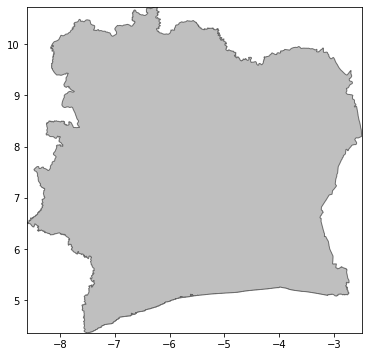

In [3]:
# Load shapefile of Cote d'Ivoire
civ = geopandas.read_file('data/gadm36_CIV_shp/gadm36_CIV_0.shp')

# Bounding box of the country
xlim = np.array(civ.bounds[['minx', 'maxx']]).flatten()
ylim = np.array(civ.bounds[['miny', 'maxy']]).flatten()

# Display country
fig, ax = plt.subplots(1, figsize = (6, 6))
for i, gi in enumerate(civ.geometry): # Add islands
     ax.add_patch(PolygonPatch(gi, color='grey', ec='k', lw=1, alpha=.5))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [4]:
# In the Equator 1 decimal degree is approx 111 km
d2km = 1/111

# Make grid of 50 km resolution
res1 = 50
grid_x50 = [xlim[0] + i * d2km for i in  np.arange(np.diff(xlim) // d2km + res1, step = res1)]
grid_y50 = [ylim[0] + i * d2km for i in  np.arange(np.diff(ylim) // d2km + res1, step = res1)]
mesh50km = np.vstack([i.ravel() for i in np.meshgrid(grid_x50, grid_y50)]).T

# Make grid of 100 km resolution
res2 = 100
grid_x100 = [xlim[0] + i * d2km for i in  np.arange(np.diff(xlim) // d2km + res2, step = res2)]
grid_y100 = [ylim[0] + i * d2km for i in  np.arange(np.diff(ylim) // d2km + res2, step = res2)]
mesh100km = np.vstack([i.ravel() for i in np.meshgrid(grid_x100, grid_y100)]).T

In [5]:
# Make Voronoi polygons
vor50 = disarm_gears.util.voronoi_polygons(mesh50km)
vor100 = disarm_gears.util.voronoi_polygons(mesh100km)

In [6]:
# Make GeoDataFrames with each mesh and discard points outside the country
## 50km
geo50 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(*mesh50km.T))
geo50 = geopandas.sjoin(geo50, civ, how='left')
ix_50 = ~geo50.index_right.isna()
geo50 = geo50.dropna()[['geometry']]
geo50.reset_index(inplace=True, drop=True)
vor50 = vor50.loc[ix_50]
vor50.reset_index(inplace=True, drop=True)

## 100km
geo100 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(*mesh100km.T))
geo100 = geopandas.sjoin(geo100, civ, how='left')
ix_100 = ~geo100.index_right.isna()
geo100 = geo100.dropna()[['geometry']]
geo100.reset_index(inplace=True, drop=True)
vor100 = vor100.loc[ix_100]
vor100.reset_index(inplace=True, drop=True)

/home/ric/miniconda3/envs/disarm_geo37/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


(4.36180687, 10.73663998)

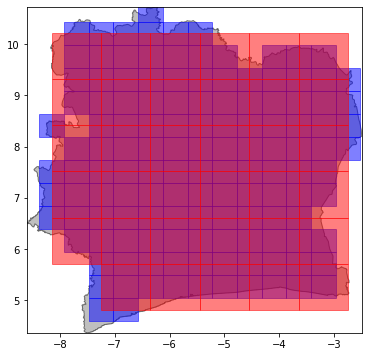

In [15]:
fig, ax = plt.subplots(1, figsize = (6, 6))
for i, gi in enumerate(civ.geometry): 
     ax.add_patch(PolygonPatch(gi, color='grey', ec='k', lw=1,alpha=.5))
for i, gi in enumerate(vor50.geometry): 
     ax.add_patch(PolygonPatch(gi, color='blue', ec='blue', lw=1,alpha=.5))
for i, gi in enumerate(vor100.geometry):
     ax.add_patch(PolygonPatch(gi, color='red', ec='red', lw=1,alpha=.5))
    
#ax.plot(geo50.geometry.x, geo50.geometry.y, 'o', color='blue', alpha=.5) 
#ax.plot(geo100.geometry.x, geo100.geometry.y, 'o', color='red', alpha=.5) 
#ax.plot(vor50.centroid.geometry.x, vor50.centroid.geometry.y, 'x', color='blue', alpha=1.) 
#ax.plot(vor100.centroid.geometry.x, vor100.centroid.geometry.y, 'o', color='red', alpha=.3) 

ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [27]:
tile50 = disarm_gears.frames.TilePattern(geometries=vor50.geometry)
sort50 = tile50.locate(np.vstack([geo50.geometry.x, geo50.geometry.y]).T)
sort50 # Polygons and points are sorted equally

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132])

In [29]:
tile100 = disarm_gears.frames.TilePattern(geometries=vor100.geometry)
sort100 = tile100.locate(np.vstack([geo100.geometry.x, geo100.geometry.y]).T)
sort100 # Polygons and points are sorted equally

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [30]:
open_faas_link = 'http://faas.srv.disarm.io/function/fn-covariate-extractor'

In [32]:
# Request data layer at 50km
req_options50 = {
            'points': json.loads(geo50.to_json()),  # TODO: Need to to-and-from JSON here?
            'layer_names': ['elev_m'],
            'resolution': 50,
        }

# Request layer at 100km
req_options100 = {
            'points': json.loads(geo100.to_json()),  # TODO: Need to to-and-from JSON here?
            'layer_names': ['bioclim1'],
            'resolution': 100,
        }

In [33]:
response50 = requests.post(open_faas_link, json=req_options50)
layer50 = response50.json()
layer50 = geopandas.GeoDataFrame.from_features(layer50['result'])

In [34]:
response100 = requests.post(open_faas_link, json=req_options100)
layer100 = response100.json()
layer100 = geopandas.GeoDataFrame.from_features(layer100['result'])

Text(0.5, 1.0, 'Bioclim1')

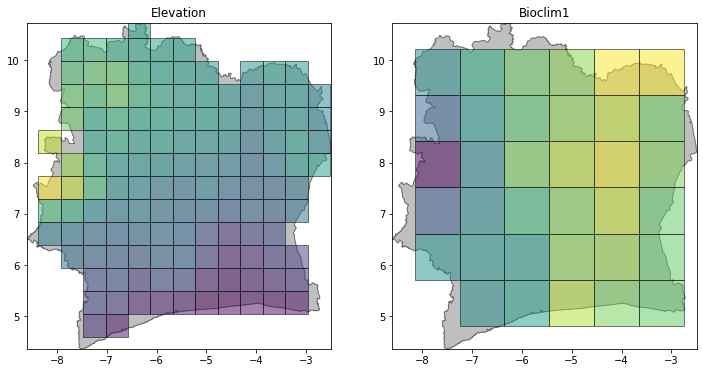

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))


z = layer50.elev_m
cmap = cm.get_cmap('viridis') # Color palette
normalizer = colors.Normalize(vmin=z.min(), vmax=z.max()) # Associate values to colors
z_color = [cmap(normalizer(zi)) for zi in z]
for i, gi in enumerate(civ.geometry): # Add islands
     ax[0].add_patch(PolygonPatch(gi, color='grey', ec='k', lw=1,alpha=.5))
for i, gi in enumerate(vor50.geometry): # Add islands
     ax[0].add_patch(PolygonPatch(gi, color=z_color[i], ec='k', lw=1,alpha=.5))
#ax[0].scatter(layer50.geometry.x, layer50.geometry.y, color=z_color, alpha=1., marker='o', lw=20) 
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_title('Elevation')

z = layer100.bioclim1
cmap = cm.get_cmap('viridis') # Color palette
normalizer = colors.Normalize(vmin=z.min(), vmax=z.max()) # Associate values to colors
z_color = [cmap(normalizer(zi)) for zi in z]
for i, gi in enumerate(civ.geometry): # Add islands
     ax[1].add_patch(PolygonPatch(gi, color='grey', ec='k', lw=1,alpha=.5))
for i, gi in enumerate(vor100.geometry): # Add islands
     ax[1].add_patch(PolygonPatch(gi, color=z_color[i], ec='k', lw=1,alpha=.5))

#ax[1].scatter(layer100.geometry.x, layer100.geometry.y, color=z_color, alpha=1., marker='o', lw=40) 
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_title('Bioclim1')